In [1]:
!pip install ta  # Thư viện tính technical indicators


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=fcd7ae09db07cc49703d8803506b10788bf663b7cc796ac71c445eddb63e9652
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


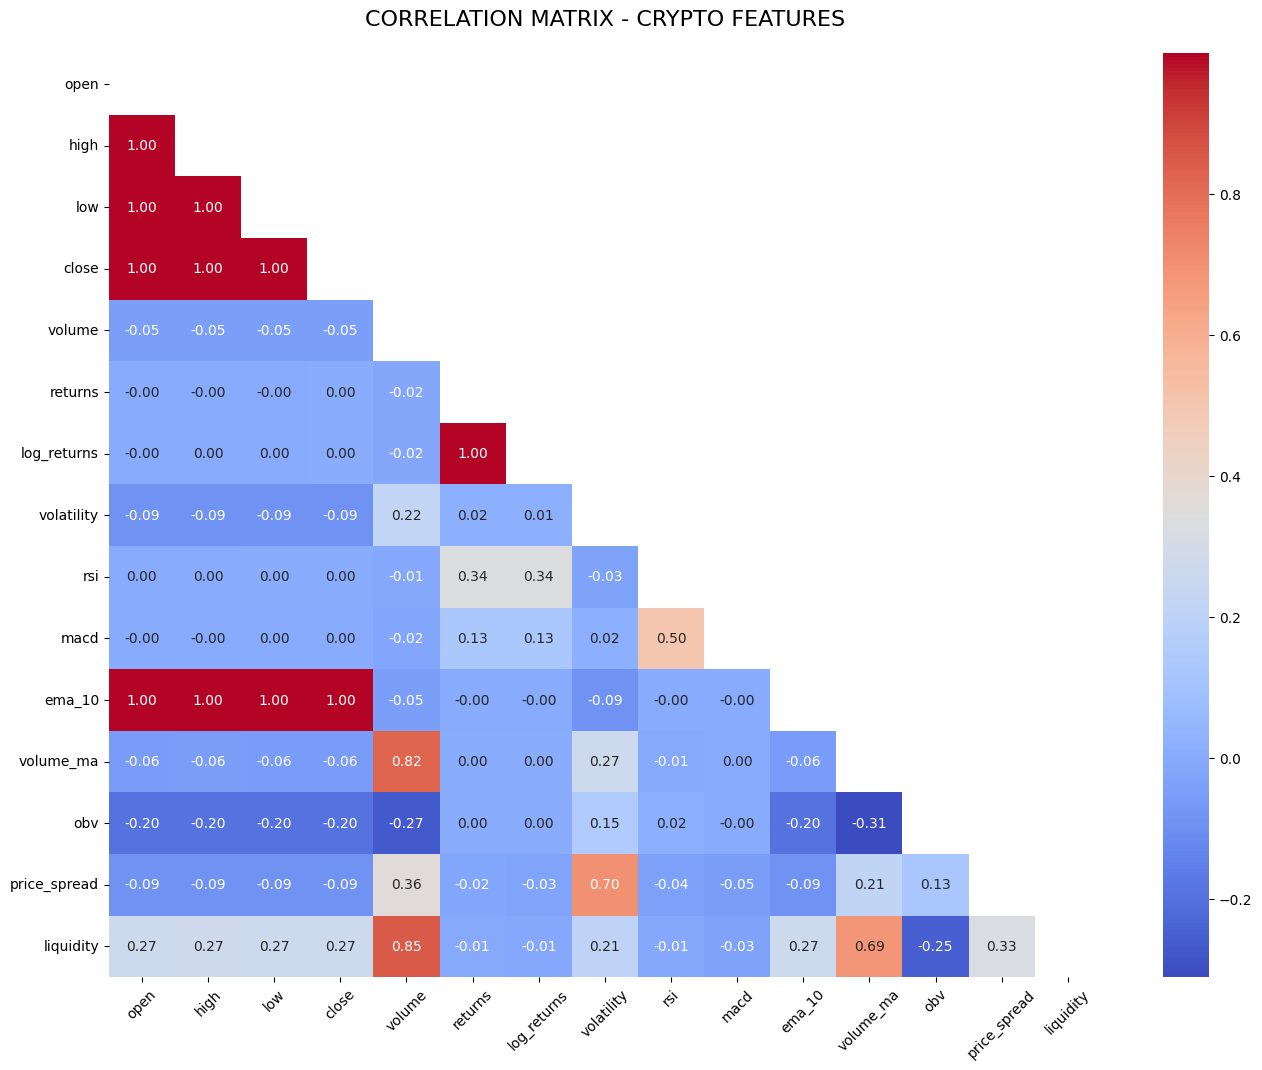


TOP FEATURES CORRELATED WITH CLOSING PRICE:


close           1.000000
high            0.999997
low             0.999997
open            0.999995
ema_10          0.999990
liquidity       0.272177
log_returns     0.001353
rsi             0.001310
returns         0.001002
macd            0.000282
volume         -0.047721
volume_ma      -0.055724
price_spread   -0.090376
volatility     -0.093334
obv            -0.195716
Name: close, dtype: float64


TRAIN-TEST TIME PERIODS:
Train: 2017-08-17 06:45:00 to 2023-07-12 06:00:00
Test:  2023-07-12 06:05:00 to 2024-12-31 23:55:00

No time leakage detected


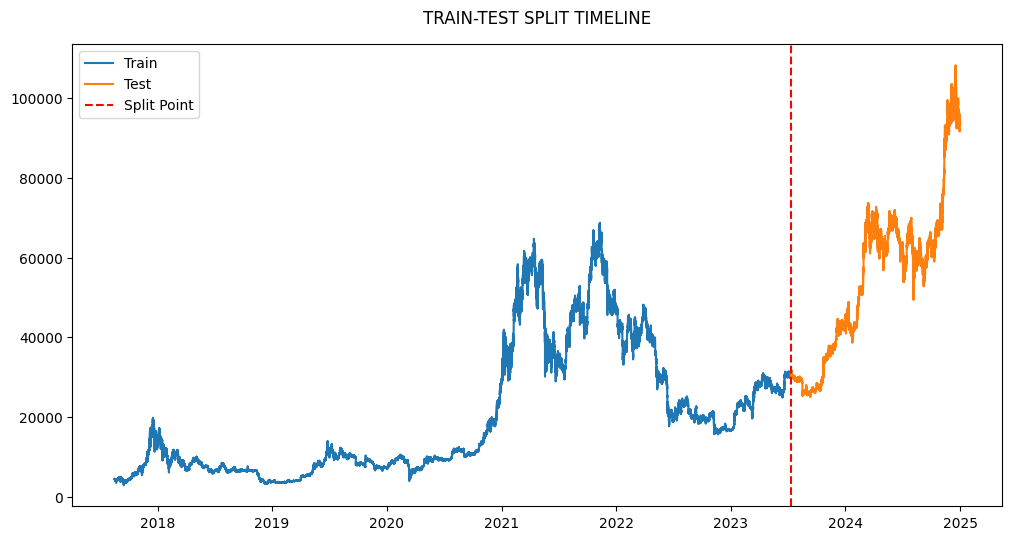


SCALING CONSISTENCY CHECK:


,Train Mean,Test Mean,Difference
close,19978.833525,55108.617376,35129.783850
volume,266.234025,120.682914,145.551111
rsi,50.431844,50.483862,0.052018
macd,0.000023,-0.001880,0.001904
volatility,0.001982,0.001215,0.000767



No obvious future-looking features detected

FEATURE DISTRIBUTIONS COMPARISON:


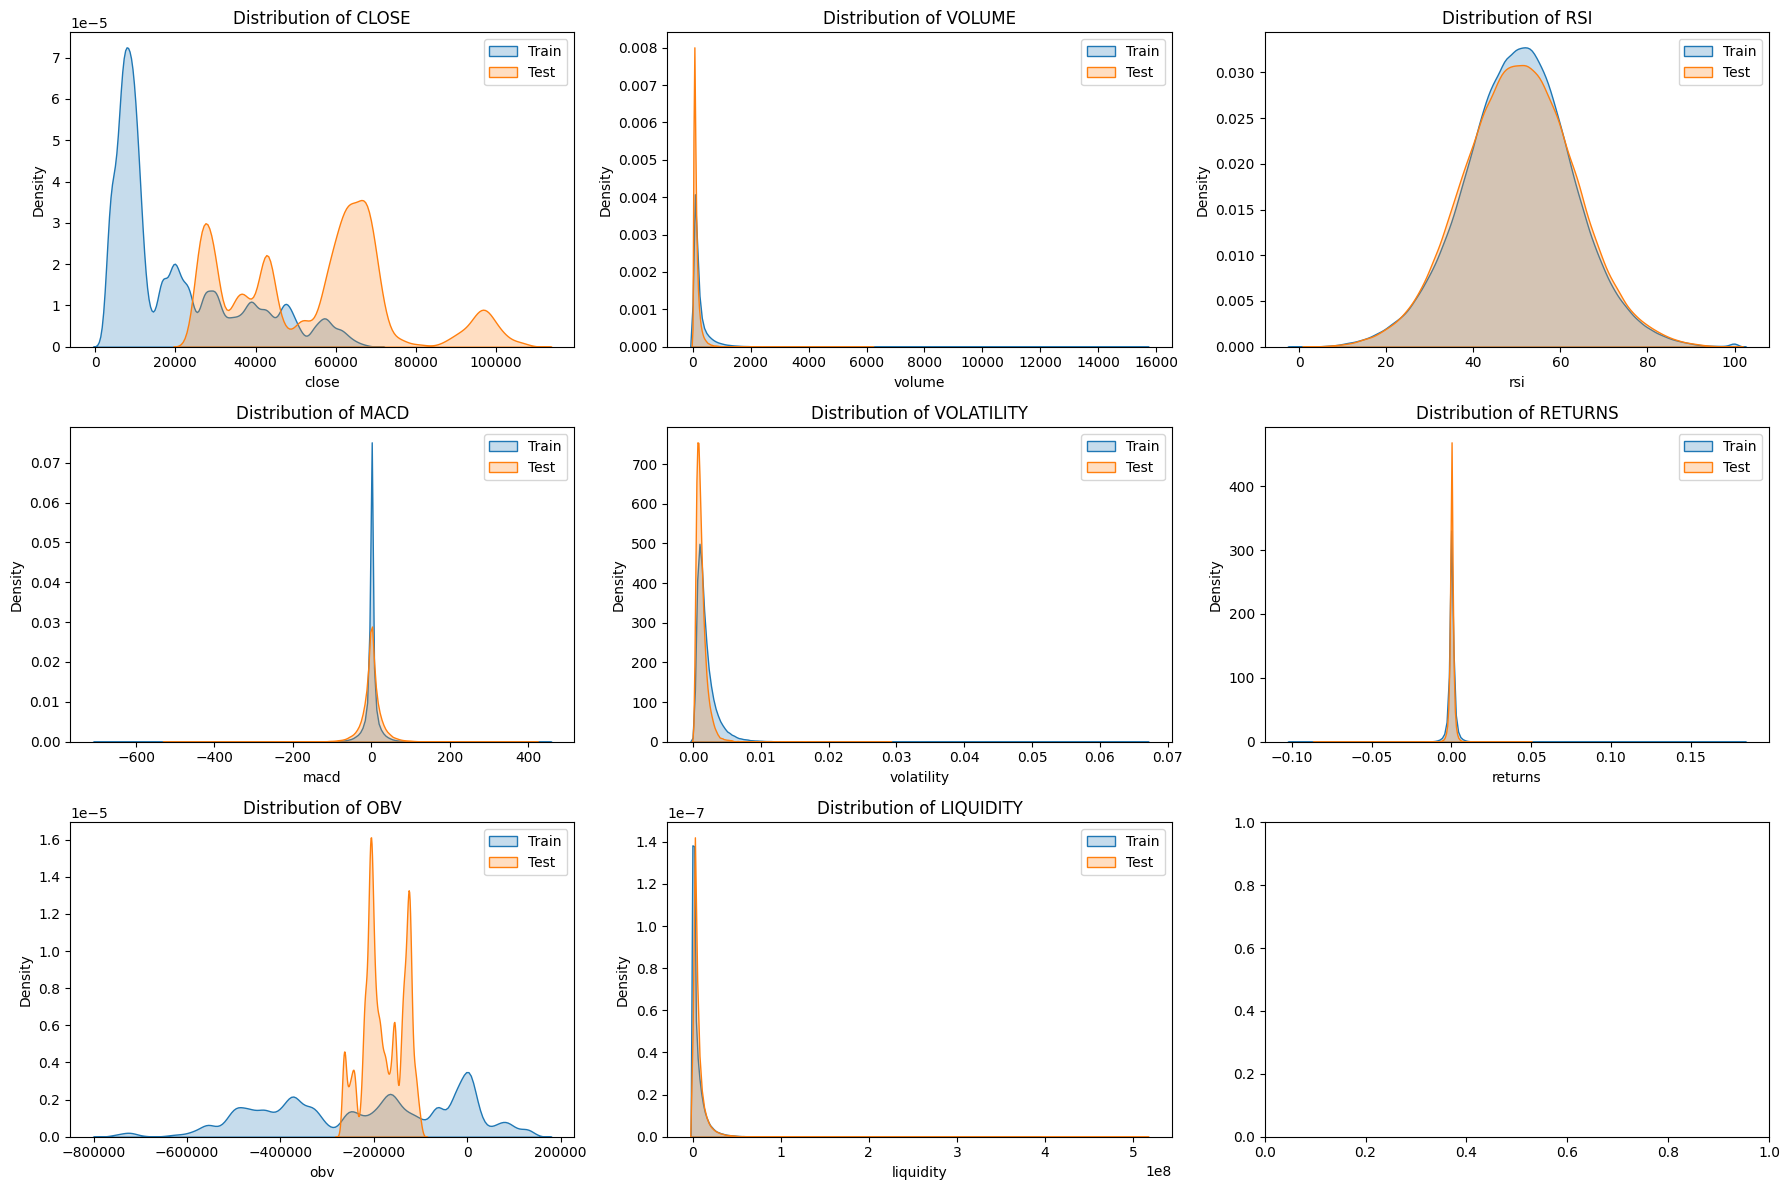

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from torch.utils.data import Subset
import warnings
warnings.filterwarnings('ignore')
import ta
# ======================
# 1. TẢI VÀ CHUẨN BỊ DỮ LIỆU
# ======================

config = {
    'data': {
        'freq': '5T',
        'train_ratio': 0.8
    },
    'model': {
        'seq_len': 60,
        'pred_len': 5,
        'enc_in': 10  # Số lượng features
    }
}

# Load dữ liệu 
df = pd.read_csv('/kaggle/input/btcusdt-5m-full/BTCUSDT_5m_full.csv', parse_dates=['timestamp'])
df = df.set_index('timestamp').sort_index()
column_map = {
            'timestamp': 'timestamp',
            'Open': 'open',
            'High': 'high',
            'Low': 'low',
            'Close': 'close',
            'Volume': 'volume'
        }
df = df.rename(columns={k: v for k, v in column_map.items() if k in df.columns})
# ======================
# 2. THÊM CÁC FEATURES
# ======================

def add_crypto_features(df, freq):
    """Thêm các features giống trong CryptoDataset"""
    if freq != '5T':
        ohlc_dict = {
            'open': 'first',
            'high': 'max',
            'low': 'min',
            'close': 'last',
            'volume': 'sum'
        }
        df = df.resample(freq).apply(ohlc_dict).dropna()
    
    # Tính toán các features
    df['returns'] = df['close'].pct_change()
    df['log_returns'] = np.log1p(df['returns'])
    df['volatility'] = df['log_returns'].rolling(12).std()
    
    # Technical indicators
    df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=10).rsi()
    df['macd'] = ta.trend.MACD(df['close'], window_slow=26, window_fast=12).macd_diff()
    df['ema_10'] = ta.trend.EMAIndicator(df['close'], window=10).ema_indicator()
    
    # Volume features
    df['volume_ma'] = df['volume'].rolling(12).mean()
    df['obv'] = ta.volume.OnBalanceVolumeIndicator(df['close'], df['volume']).on_balance_volume()
    
    # Price features
    df['price_spread'] = (df['high'] - df['low']) / df['close']
    df['liquidity'] = df['volume'] * df['close']
    
    return df.dropna()

df = add_crypto_features(df, config['data']['freq'])

# ======================
# 3. KIỂM TRA CORRELATION
# ======================

plt.figure(figsize=(16, 12))
corr_matrix = df.corr()
target_corr = corr_matrix['close'].sort_values(ascending=False)

# Heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            mask=np.triu(np.ones_like(corr_matrix, dtype=bool)))
plt.title("CORRELATION MATRIX - CRYPTO FEATURES", pad=20, fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Top features liên quan đến giá đóng cửa
print("\nTOP FEATURES CORRELATED WITH CLOSING PRICE:")
display(target_corr.head(20))

# ======================
# 4. KIỂM TRA DATA LEAKAGE
# ======================

# Chia dữ liệu train/test theo thời gian
split_idx = int(len(df) * config['data']['train_ratio'])
train_data = df.iloc[:split_idx]
test_data = df.iloc[split_idx:]

# 4.1 Kiểm tra thời gian
print("\nTRAIN-TEST TIME PERIODS:")
print(f"Train: {train_data.index.min()} to {train_data.index.max()}")
print(f"Test:  {test_data.index.min()} to {test_data.index.max()}")

if test_data.index.min() <= train_data.index.max():
    print("\nWARNING: Potential DATA LEAKAGE - Test period overlaps with training period")
else:
    print("\nNo time leakage detected")

# 4.2 Kiểm tra phân phối
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['close'], label='Train')
plt.plot(test_data.index, test_data['close'], label='Test')
plt.axvline(x=train_data.index.max(), color='r', linestyle='--', label='Split Point')
plt.title("TRAIN-TEST SPLIT TIMELINE", pad=15)
plt.legend()
plt.show()

# 4.3 Kiểm tra scaling 
numeric_features = ['close', 'volume', 'rsi', 'macd', 'volatility']
scaler_check = pd.DataFrame({
    'Train Mean': train_data[numeric_features].mean(),
    'Test Mean': test_data[numeric_features].mean(),
    'Difference': (train_data[numeric_features].mean() - test_data[numeric_features].mean()).abs()
})

print("\nSCALING CONSISTENCY CHECK:")
display(scaler_check)

# 4.4 Kiểm tra các features sử dụng thông tin tương lai
future_leak_features = []
for col in df.columns:
    if any(x in col.lower() for x in ['future', 'next', 'shift', 'lead']):
        future_leak_features.append(col)

if future_leak_features:
    print("\nWARNING: Potential FUTURE LEAKAGE in features:", future_leak_features)
else:
    print("\nNo obvious future-looking features detected")

# ======================
# 5. VISUALIZE PHÂN PHỐI
# ======================

print("\nFEATURE DISTRIBUTIONS COMPARISON:")
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
features_to_plot = ['close', 'volume', 'rsi', 'macd', 'volatility', 'returns', 'obv', 'liquidity']

for i, feat in enumerate(features_to_plot):
    ax = axes[i//3, i%3]
    sns.kdeplot(train_data[feat], ax=ax, label='Train', fill=True)
    sns.kdeplot(test_data[feat], ax=ax, label='Test', fill=True)
    ax.set_title(f'Distribution of {feat.upper()}')
    ax.legend()

plt.tight_layout()
plt.show()

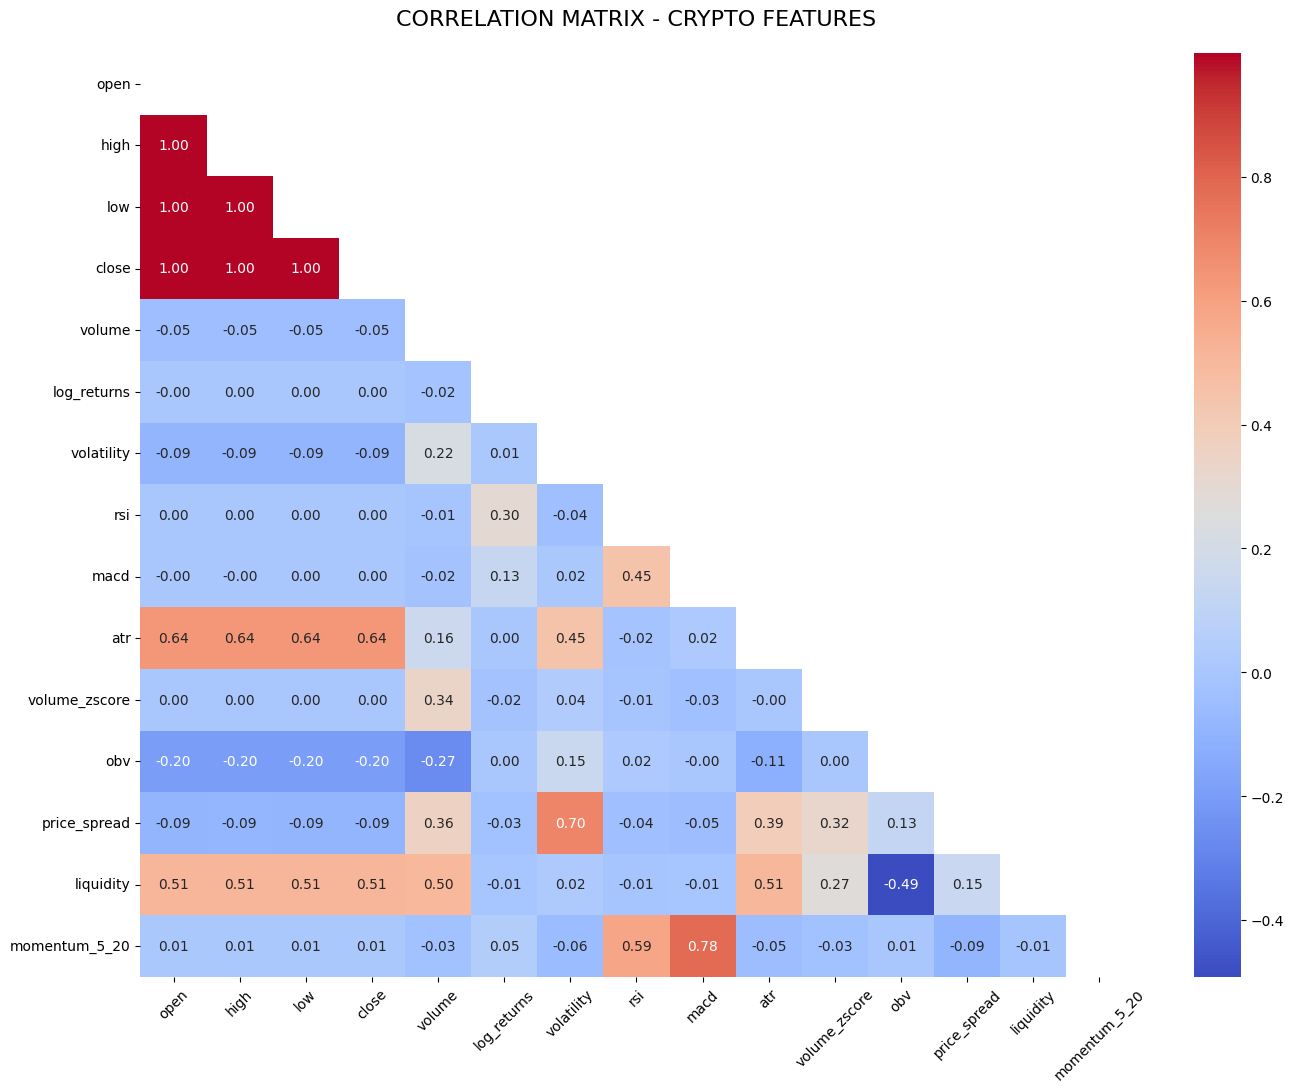


TOP FEATURES CORRELATED WITH CLOSING PRICE:


close            1.000000
high             0.999997
low              0.999997
open             0.999995
atr              0.636130
liquidity        0.514113
momentum_5_20    0.012456
rsi              0.003826
volume_zscore    0.001398
log_returns      0.001353
macd             0.000282
volume          -0.047721
price_spread    -0.090376
volatility      -0.093334
obv             -0.195716
Name: close, dtype: float64


TRAIN-TEST TIME PERIODS:
Train: 2017-08-17 06:45:00 to 2023-07-12 06:00:00
Test:  2023-07-12 06:05:00 to 2024-12-31 23:55:00

No time leakage detected


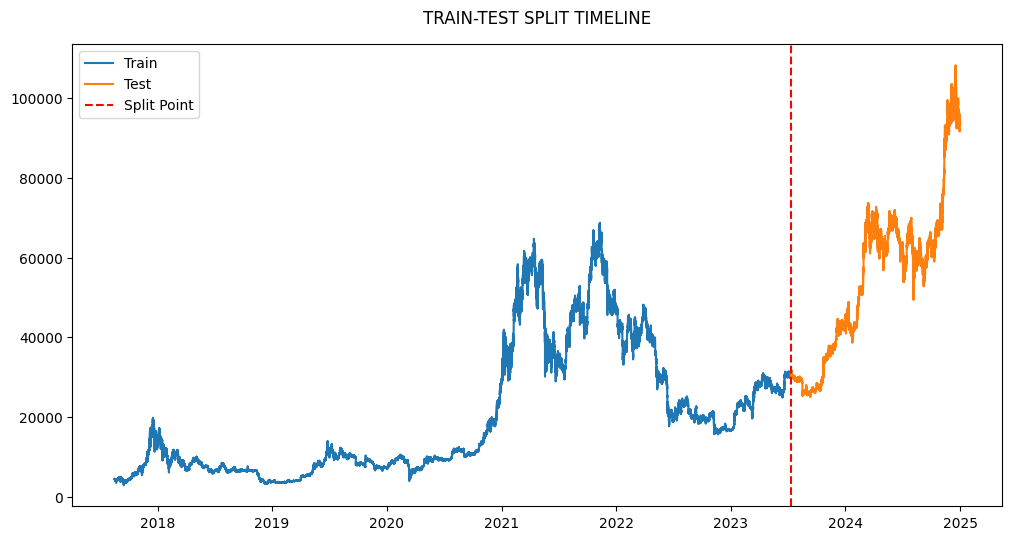


SCALING CONSISTENCY CHECK:


,Train Mean,Test Mean,Difference
close,19978.833525,55108.617376,35129.783850
volume,266.234025,120.682914,145.551111
rsi,50.401941,50.475667,0.073726
macd,0.000023,-0.001880,0.001904
volatility,0.001982,0.001215,0.000767



No obvious future-looking features detected

FEATURE DISTRIBUTIONS COMPARISON:


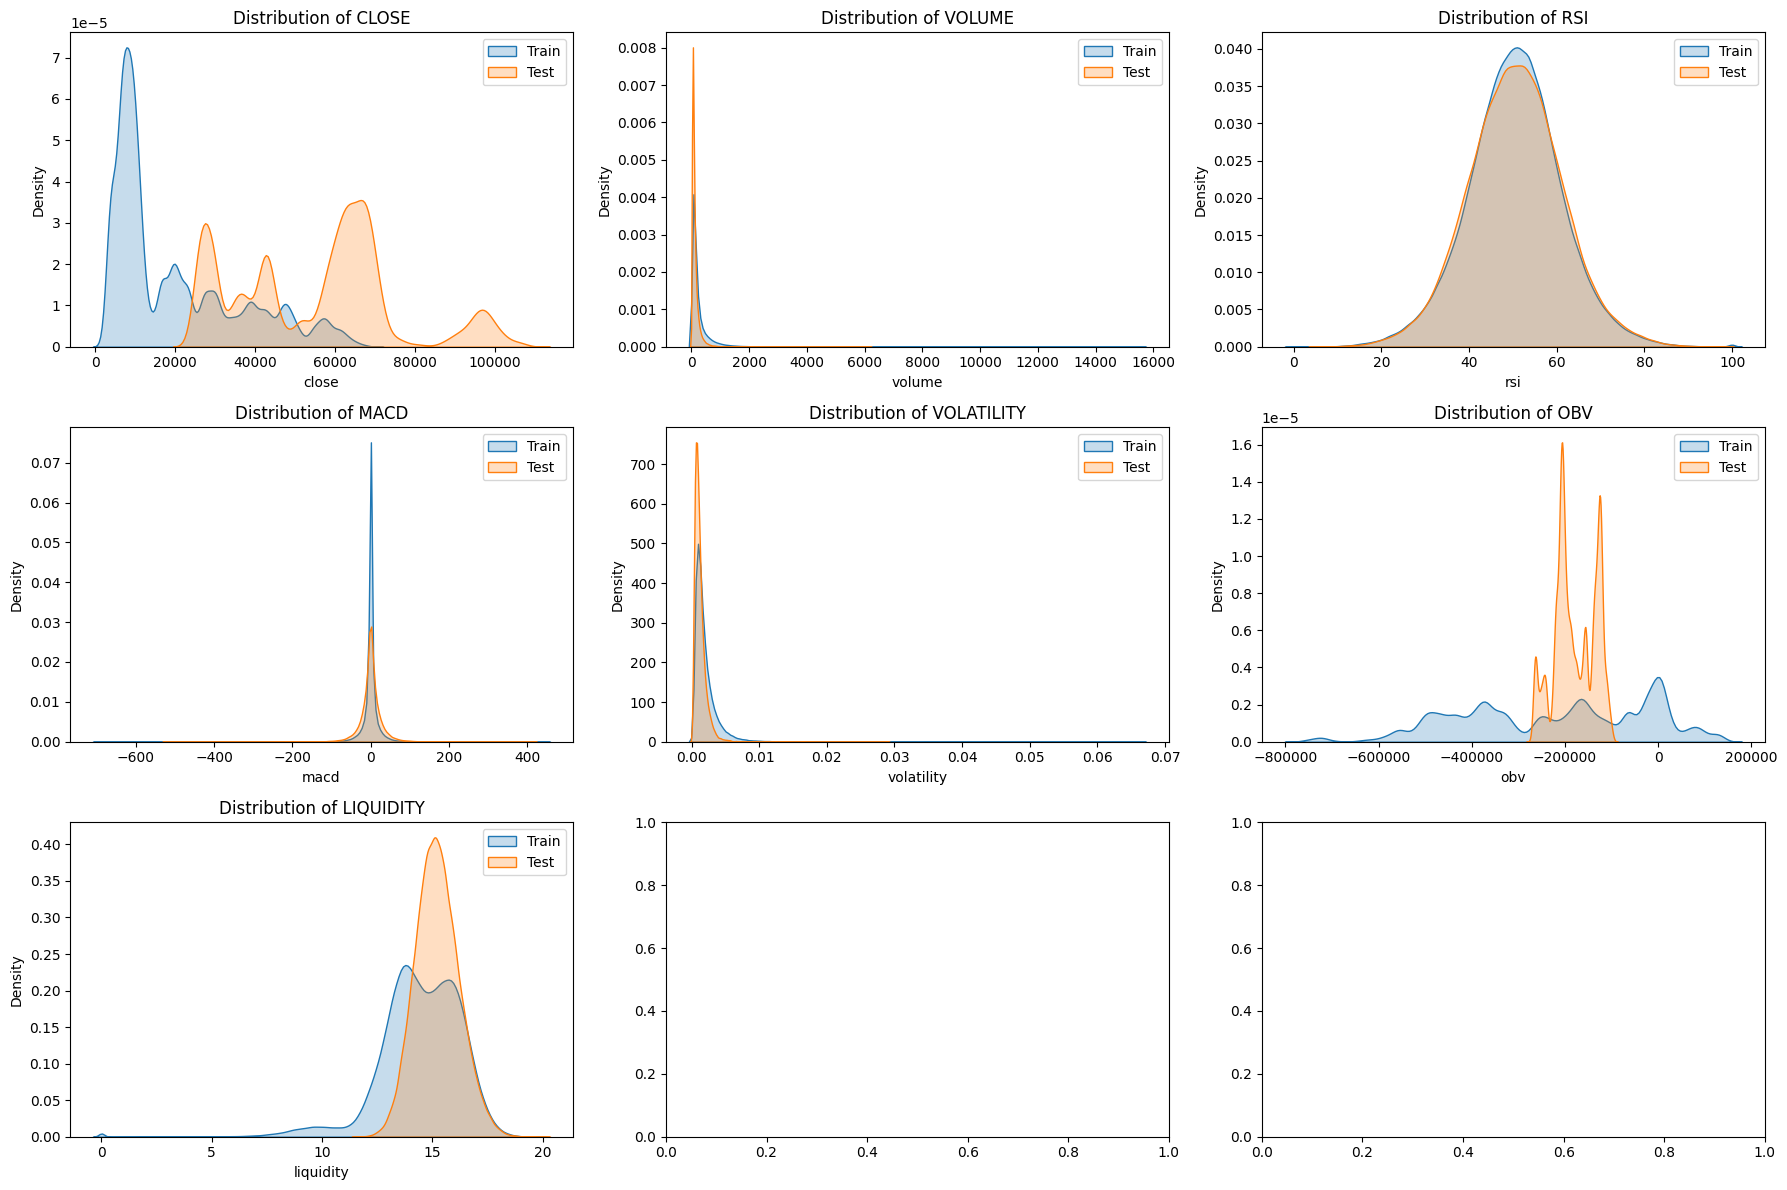

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from torch.utils.data import Subset
import warnings
warnings.filterwarnings('ignore')
import ta
# ======================
# 1. TẢI VÀ CHUẨN BỊ DỮ LIỆU
# ======================

config = {
    'data': {
        'freq': '5T',
        'train_ratio': 0.8
    },
    'model': {
        'seq_len': 60,
        'pred_len': 5,
        'enc_in': 10  # Số lượng features
    }
}

# Load dữ liệu 
df = pd.read_csv('/kaggle/input/btcusdt-5m-full/BTCUSDT_5m_full.csv', parse_dates=['timestamp'])
df = df.set_index('timestamp').sort_index()
column_map = {
            'timestamp': 'timestamp',
            'Open': 'open',
            'High': 'high',
            'Low': 'low',
            'Close': 'close',
            'Volume': 'volume'
        }
df = df.rename(columns={k: v for k, v in column_map.items() if k in df.columns})
# ======================
# 2. THÊM CÁC FEATURES
# ======================

def add_crypto_features(df, freq):
    """Thêm các features giống trong CryptoDataset"""
    if freq != '5T':
        ohlc_dict = {
            'open': 'first',
            'high': 'max',
            'low': 'min',
            'close': 'last',
            'volume': 'sum'
        }
        df = df.resample(freq).apply(ohlc_dict).dropna()
    
    # Tính toán các features
    df['log_returns'] = np.log1p(df['close'].pct_change())
    df['volatility'] = df['log_returns'].rolling(12).std()
        
    # Technical indicators cải tiến
    df['rsi'] = ta.momentum.RSIIndicator(df['close'], window=14).rsi()
    df['macd'] = ta.trend.MACD(df['close'], window_slow=26, window_fast=12).macd_diff()
    df['atr'] = ta.volatility.AverageTrueRange(df['high'], df['low'], df['close'], window=14).average_true_range()
        
    # Volume features cải tiến
    df['volume_zscore'] = (df['volume'] - df['volume'].rolling(24).mean()) / df['volume'].rolling(24).std()
    df['obv'] = ta.volume.OnBalanceVolumeIndicator(df['close'], df['volume']).on_balance_volume()
        
    # Price features cải tiến
    df['price_spread'] = (df['high'] - df['low']) / df['close']
    df['liquidity'] = np.log1p(df['volume'] * df['close'])  # Log transform
        
    # Momentum features 
    df['momentum_5_20'] = df['close'].rolling(5).mean() - df['close'].rolling(20).mean()
    return df.dropna()

df = add_crypto_features(df, config['data']['freq'])

# ======================
# 3. KIỂM TRA CORRELATION
# ======================

plt.figure(figsize=(16, 12))
corr_matrix = df.corr()
target_corr = corr_matrix['close'].sort_values(ascending=False)

# Heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            mask=np.triu(np.ones_like(corr_matrix, dtype=bool)))
plt.title("CORRELATION MATRIX - CRYPTO FEATURES", pad=20, fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Top features liên quan đến giá đóng cửa
print("\nTOP FEATURES CORRELATED WITH CLOSING PRICE:")
display(target_corr.head(20))

# ======================
# 4. KIỂM TRA DATA LEAKAGE
# ======================

# Chia dữ liệu train/test theo thời gian
split_idx = int(len(df) * config['data']['train_ratio'])
train_data = df.iloc[:split_idx]
test_data = df.iloc[split_idx:]

# 4.1 Kiểm tra thời gian
print("\nTRAIN-TEST TIME PERIODS:")
print(f"Train: {train_data.index.min()} to {train_data.index.max()}")
print(f"Test:  {test_data.index.min()} to {test_data.index.max()}")

if test_data.index.min() <= train_data.index.max():
    print("\nWARNING: Potential DATA LEAKAGE - Test period overlaps with training period")
else:
    print("\nNo time leakage detected")

# 4.2 Kiểm tra phân phối
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['close'], label='Train')
plt.plot(test_data.index, test_data['close'], label='Test')
plt.axvline(x=train_data.index.max(), color='r', linestyle='--', label='Split Point')
plt.title("TRAIN-TEST SPLIT TIMELINE", pad=15)
plt.legend()
plt.show()

# 4.3 Kiểm tra scaling 
numeric_features = ['close', 'volume', 'rsi', 'macd', 'volatility']
scaler_check = pd.DataFrame({
    'Train Mean': train_data[numeric_features].mean(),
    'Test Mean': test_data[numeric_features].mean(),
    'Difference': (train_data[numeric_features].mean() - test_data[numeric_features].mean()).abs()
})

print("\nSCALING CONSISTENCY CHECK:")
display(scaler_check)

# 4.4 Kiểm tra các features sử dụng thông tin tương lai
future_leak_features = []
for col in df.columns:
    if any(x in col.lower() for x in ['future', 'next', 'shift', 'lead']):
        future_leak_features.append(col)

if future_leak_features:
    print("\nWARNING: Potential FUTURE LEAKAGE in features:", future_leak_features)
else:
    print("\nNo obvious future-looking features detected")

# ======================
# 5. VISUALIZE PHÂN PHỐI
# ======================

print("\nFEATURE DISTRIBUTIONS COMPARISON:")
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
features_to_plot = ['close', 'volume', 'rsi', 'macd', 'volatility', 'obv', 'liquidity']

for i, feat in enumerate(features_to_plot):
    ax = axes[i//3, i%3]
    sns.kdeplot(train_data[feat], ax=ax, label='Train', fill=True)
    sns.kdeplot(test_data[feat], ax=ax, label='Test', fill=True)
    ax.set_title(f'Distribution of {feat.upper()}')
    ax.legend()

plt.tight_layout()
plt.show()

In [30]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Chọn các đặc trưng numeric 
vif_features = df.select_dtypes(include=[np.number]).drop(columns=['close'], errors='ignore').dropna()

# Tính VIF
vif_data = pd.DataFrame()
vif_data["feature"] = vif_features.columns
vif_data["VIF"] = [variance_inflation_factor(vif_features.values, i) for i in range(vif_features.shape[1])]

print("\nVARIANCE INFLATION FACTOR (VIF) ANALYSIS:")
display(vif_data.sort_values(by="VIF", ascending=False))



VARIANCE INFLATION FACTOR (VIF) ANALYSIS:


,feature,VIF
0,open,1.193169e+06
1,high,1.109630e+06
2,low,9.172505e+05
12,liquidity,4.632463e+01
6,rsi,3.184805e+01
8,atr,1.030705e+01
11,price_spread,6.207822e+00
5,volatility,5.508116e+00
10,obv,3.304098e+00
13,momentum_5_20,3.199970e+00
